In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the CSV file into a DataFrame
combined_season_data = pd.read_csv('combined_season_data.csv')

# Display the first few rows of the DataFrame
combined_season_data.head()

,Unnamed: 0,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,HY,AY,HR,AR,HAGR,AAGR,HAGCR,AAGCR,NAGR,NAGCR
0,0,2002-2003,17/08/2002,Blackburn,Sunderland,0.0,0.0,D,0.0,0.0,...,1.0,2.0,0.0,0.0,0.882324,0.750135,0.990630,1.145987,0.816229,1.068309
1,1,2002-2003,17/08/2002,Charlton,Chelsea,2.0,3.0,A,2.0,1.0,...,0.0,3.0,1.0,0.0,0.861645,1.372106,1.167044,0.664697,1.116875,0.915870
2,2,2002-2003,17/08/2002,Everton,Tottenham,2.0,2.0,D,1.0,0.0,...,1.0,1.0,0.0,0.0,1.012637,1.217017,0.939149,0.914164,1.114827,0.926656
3,3,2002-2003,17/08/2002,Fulham,Bolton,4.0,1.0,H,3.0,1.0,...,1.0,2.0,0.0,0.0,0.896110,0.873021,1.133872,1.109798,0.884566,1.121835
4,4,2002-2003,17/08/2002,Leeds,Man City,3.0,0.0,H,2.0,0.0,...,1.0,1.0,0.0,0.0,0.847858,1.391492,1.384168,0.761530,1.119675,1.072849


## Competitiveness Measures

### HICB and nHHI

In [3]:
data = combined_season_data.copy()

In [4]:
# Creating a function to determine points for a match
def determine_points(result):
    if result == 'H':
        return 3
    elif result == 'D':
        return 1
    else:
        return 0

# Calculating points for home and away teams
data['HomePoints'] = data['FTR'].apply(lambda x: determine_points(x))
data['AwayPoints'] = data['FTR'].apply(lambda x: determine_points('A' if x == 'H' else ('H' if x == 'A' else 'D')))

# Grouping by season and team to get the total points for each team in each season
home_points = data.groupby(['Season', 'HomeTeam'])['HomePoints', 'HAGR', 'HAGCR'].sum().reset_index()
away_points = data.groupby(['Season', 'AwayTeam'])['AwayPoints', 'AAGR', 'AAGCR'].sum().reset_index()

# Renaming columns for merging
home_points.rename(columns={'HomeTeam': 'Team', 'HomePoints': 'Points', 'HAGR': 'NAGR', 'HAGCR': 'NAGCR'}, inplace=True)
away_points.rename(columns={'AwayTeam': 'Team', 'AwayPoints': 'Points', 'AAGR': 'NAGR', 'AAGCR': 'NAGCR'}, inplace=True)

# Merging home and away data
total_points = pd.concat([home_points, away_points]).groupby(['Season', 'Team']).sum().reset_index()

total_points.head()


,Season,Team,Points,NAGR,NAGCR
0,2002-2003,Arsenal,78,53.316413,29.798896
1,2002-2003,Aston Villa,45,34.378770,39.778947
2,2002-2003,Birmingham,48,28.783529,37.770009
3,2002-2003,Blackburn,60,34.554786,39.908135
4,2002-2003,Bolton,44,33.482525,40.767586


In [5]:

# Defining the function to calculate HHI, HHI*, and HICB
def calculate_hhi_values(season_data, column):
    N = len(season_data)
    total = season_data[column].sum()
    
    # Calculate the squared market shares for each team
    season_data['Squared_Share'] = (season_data[column] / total) ** 2
    
    # HHI calculation
    hhi = season_data['Squared_Share'].sum()
    
    # HHI* calculation
    hhi_star = (hhi - (1 / N)) / (1 - (1 / N))
    
    # HICB calculation
    hicb = (hhi / (1 / N)) * 100
    
    return hhi, hhi_star, hicb

# Lists to store the results
seasons = []
hhi_points, hhi_nagr, hhi_nagcr = [], [], []
hhi_star_points, hhi_star_nagr, hhi_star_nagcr = [], [], []
hicb_points, hicb_nagr, hicb_nagcr = [], [], []

for season, season_data in total_points.groupby('Season'):
    seasons.append(season)
    
    hhi_p, hhi_star_p, hicb_p = calculate_hhi_values(season_data, 'Points')
    hhi_n, hhi_star_n, hicb_n = calculate_hhi_values(season_data, 'NAGR')
    hhi_c, hhi_star_c, hicb_c = calculate_hhi_values(season_data, 'NAGCR')
    
    hhi_points.append(hhi_p)
    hhi_star_points.append(hhi_star_p)
    hicb_points.append(hicb_p)
    
    hhi_nagr.append(hhi_n)
    hhi_star_nagr.append(hhi_star_n)
    hicb_nagr.append(hicb_n)
    
    hhi_nagcr.append(hhi_c)
    hhi_star_nagcr.append(hhi_star_c)
    hicb_nagcr.append(hicb_c)

# Combining results into a DataFrame
results_df = pd.DataFrame({
    'Season': seasons,
    'HHI_Points': hhi_points,
    'HHI_NAGR': hhi_nagr,
    'HHI_NAGCR': hhi_nagcr,
    'HHI*_Points': hhi_star_points,
    'HHI*_NAGR': hhi_star_nagr,
    'HHI*_NAGCR': hhi_star_nagcr,
    'HICB_Points': hicb_points,
    'HICB_NAGR': hicb_nagr,
    'HICB_NAGCR': hicb_nagcr
})

results_df


,Season,HHI_Points,HHI_NAGR,HHI_NAGCR,HHI*_Points,HHI*_NAGR,HHI*_NAGCR,HICB_Points,HICB_NAGR,HICB_NAGCR
0,2002-2003,0.054046,0.052659,0.051607,0.004259,0.002799,0.001692,108.092517,105.317303,103.214390
1,2003-2004,0.054110,0.052484,0.051530,0.004326,0.002615,0.001610,108.219158,104.968100,103.059112
2,2004-2005,0.055227,0.052949,0.051562,0.005502,0.003105,0.001644,110.453389,105.898646,103.123133
3,2005-2006,0.055824,0.052950,0.051361,0.006130,0.003105,0.001432,111.647311,105.899729,102.721307
4,2006-2007,0.054397,0.053088,0.051487,0.004628,0.003250,0.001565,108.793439,106.175636,102.973170
5,2007-2008,0.056842,0.053807,0.052717,0.007202,0.004007,0.002860,113.683432,107.613623,105.433758
6,2008-2009,0.055808,0.053119,0.051510,0.006114,0.003283,0.001590,111.616594,106.237301,103.020591
7,2009-2010,0.055739,0.053360,0.051506,0.006041,0.003537,0.001585,111.478105,106.720148,103.011777
8,2010-2011,0.052931,0.052898,0.052057,0.003085,0.003051,0.002166,105.861031,105.796768,104.114646
9,2011-2012,0.055271,0.053295,0.051822,0.005549,0.003469,0.001918,110.542789,106.590269,103.644933


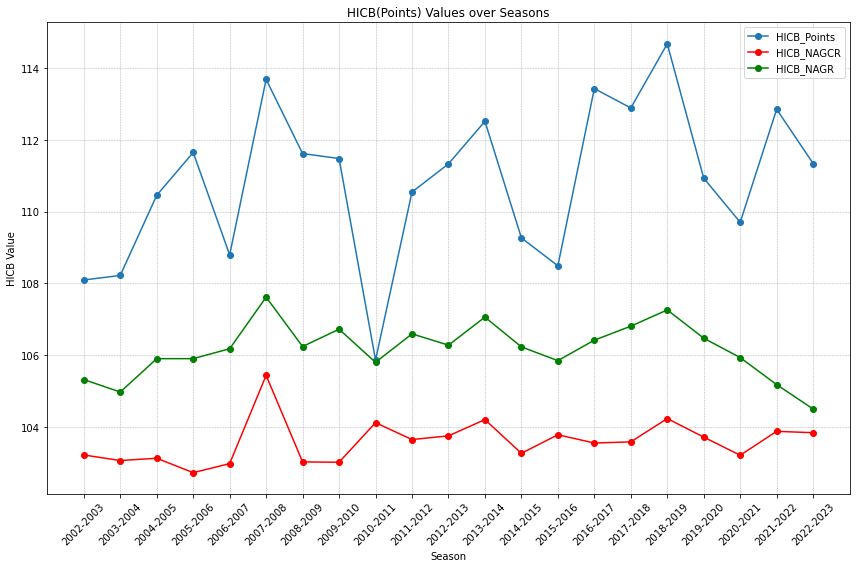

In [20]:
plt.figure(figsize=(12, 8))

# Plotting σL for each metric across seasons
plt.plot(results_df['Season'], results_df['HICB_Points'], marker='o', linestyle='-', label='HICB_Points')
plt.plot(results_df['Season'], results_df['HICB_NAGCR'], marker='o', linestyle='-', color='r', label='HICB_NAGCR')
plt.plot(results_df['Season'], results_df['HICB_NAGR'], marker='o', linestyle='-', color='g', label='HICB_NAGR')
# Setting labels, title, and legend
plt.xticks(rotation=45)
plt.title('HICB(Points) Values over Seasons')
plt.ylabel('HICB Value')
plt.xlabel('Season')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
# Save the plot as a PDF
file_path = "C:/Users/HP/Desktop/DissertationPrograms/Final_Work/Images/pdf/HICB.pdf"
plt.savefig(file_path)
plt.show()

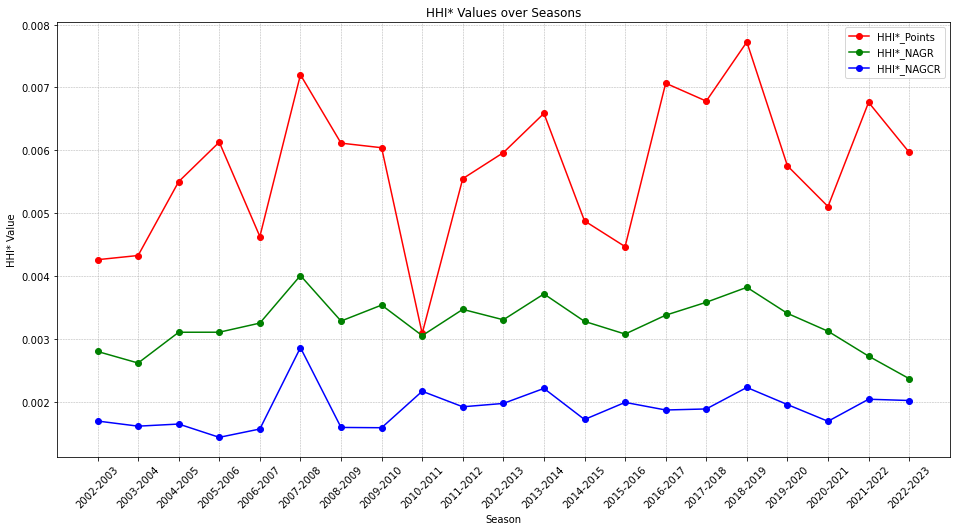

In [18]:
# Plotting HHI* values
plt.figure(figsize=(16, 8))
plt.plot(results_df['Season'], results_df['HHI*_Points'], marker='o', linestyle='-', color='red', label='HHI*_Points')
plt.plot(results_df['Season'], results_df['HHI*_NAGR'], marker='o', linestyle='-', color='green', label='HHI*_NAGR')
plt.plot(results_df['Season'], results_df['HHI*_NAGCR'], marker='o', linestyle='-', color='blue', label='HHI*_NAGCR')
plt.xticks(rotation=45)
plt.title('HHI* Values over Seasons')
plt.ylabel('HHI* Value')
plt.xlabel('Season')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# Save the plot as a PDF
file_path = "C:/Users/HP/Desktop/DissertationPrograms/Final_Work/Images/pdf/HHI_star.pdf"
plt.savefig(file_path)
plt.show()


In [7]:
from sklearn.linear_model import LinearRegression

# Most and least competitive year based on HHI* for Points
most_competitive_year_hhi_star = results_df['Season'][results_df['HHI*_Points'].idxmin()]
least_competitive_year_hhi_star = results_df['Season'][results_df['HHI*_Points'].idxmax()]

# Most and least competitive year based on HICB for Points
most_competitive_year_hicb = results_df['Season'][results_df['HICB_Points'].idxmin()]
least_competitive_year_hicb = results_df['Season'][results_df['HICB_Points'].idxmax()]


# Assigning trend labels
def determine_trend(value):
    if value > 0.01:  # Threshold of 1% used to determine if value is effectively increasing
        return "Increasing"
    elif value < -0.01:  # Threshold of -1% used to determine if value is effectively decreasing
        return "Declining"
    else:
        return "Stable"

# Current trend of competitiveness balance for HHI* for Points
recent_hhi_star_trend = results_df['HHI*_Points'].tail(5).pct_change().mean()
current_trend_hhi_star = determine_trend(recent_hhi_star_trend)

# Current trend of competitiveness balance for HICB for Points
recent_hicb_trend = results_df['HICB_Points'].tail(5).pct_change().mean()
current_trend_hicb = determine_trend(recent_hicb_trend)

# Forecasting future trend using Linear Regression
X = np.array(range(len(results_df))).reshape(-1, 1)

# For HHI*
model_hhi_star = LinearRegression().fit(X, results_df['HHI*_Points'])
forecast_hhi_star = model_hhi_star.predict(X[-5:])  # Last 5 seasons
future_trend_hhi_star = determine_trend(np.mean(np.diff(forecast_hhi_star)))

# For HICB
model_hicb = LinearRegression().fit(X, results_df['HICB_Points'])
forecast_hicb = model_hicb.predict(X[-5:])  # Last 5 seasons
future_trend_hicb = determine_trend(np.mean(np.diff(forecast_hicb)))

most_competitive_year_hhi_star, least_competitive_year_hhi_star, current_trend_hhi_star, future_trend_hhi_star, most_competitive_year_hicb, least_competitive_year_hicb, current_trend_hicb, future_trend_hicb


('2010-2011',
 '2018-2019',
 'Declining',
 'Stable',
 '2010-2011',
 '2018-2019',
 'Stable',
 'Increasing')